In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec as gd
import os
import pickle as pc
import utils1 as utl
from astropy.io import fits
from astroquery.mast import Observations as obs
from scipy import interpolate as inp
import matplotlib.cm as cm
import matplotlib.colors as cls
from scipy.optimize import curve_fit as cft
from pylab import *
import seaborn as sns

In [2]:
path1 = '/home/jayshil/Documents/Dissertation'

In [3]:
name = np.loadtxt('data2.dat', dtype = str, usecols = 0, unpack = True)
teff, lg, mh, vturb, p, pperr, pnerr, tc, aste, asteperr, astenerr, \
ecc, ome, rprst, rprstperr, rprstnerr, tce \
= np.loadtxt('data2.dat', usecols = (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17), unpack = True)

Accessing the values of empirical values of LDCs

In [4]:
u1_j, u1_jp, u1_jn, u2_j, u2_jp, u2_jn \
= np.loadtxt(path1 + '/Results/cal_us_and_evidance/cal_u1_u2.dat', usecols = (1,2,3,4,5,6), unpack = True)

u1max_j = np.max(u1_j)
u1min_j = np.min(u1_j)
u2max_j = np.max(u2_j)
u2min_j = np.min(u2_j)

Now, the theoretical values (for Claret 2017 ATLAS limiting LDCs)

In [5]:
u1_c_a, u2_c_a = np.loadtxt(path1 + '/Atlas/claret_limiting_LDC_ata.dat', usecols = (1,2), unpack = True)

u1max_c_a = np.max(u1_c_a)
u1min_c_a = np.min(u1_c_a)
u2max_c_a = np.max(u2_c_a)
u2min_c_a = np.min(u2_c_a)

Finding residuals...

In [6]:
diff_u2_c_a = np.array([])
diff_u2_c_ae = np.array([])

for i in range(len(u2_j)):
    u22_c_a = np.random.normal(u2_c_a[i], 0, 10000)
    u22_j = np.random.normal(u2_j[i], u2_jp[i], 10000)
    diff2 = u22_c_a - u22_j
    u22_m = np.median(diff2)
    u22_e = np.std(diff2)
    diff_u2_c_a = np.hstack((diff_u2_c_a, u22_m))
    diff_u2_c_ae = np.hstack((diff_u2_c_ae, u22_e))

Let's first plot it...

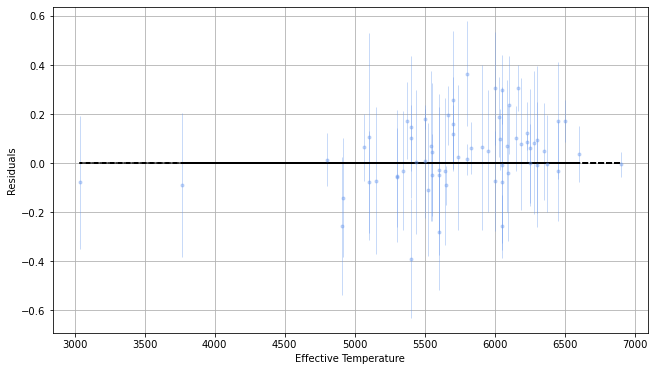

In [7]:
plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(teff, diff_u2_c_a, yerr = [u2_jn, u2_jp], fmt='.', elinewidth=1, alpha=0.35, color='cornflowerblue')
plt.plot(teff, np.zeros(len(teff)), 'k--')
plt.xlabel('Effective Temperature')
plt.ylabel('Residuals')
plt.grid()
plt.show()

Let's try to fit several models to the data, and check the best fit model using BIC

In [8]:
def line(x,m,c):
    function = m*x + c
    return function

def constant(x, c):
    function = c + x*0
    return function

def quadratic(x, a, b, c):
    function = a*x*x + b*x + c
    return function

In [9]:
# I am making a function to do fitting for three different models,
# Because I would need to do this again and again
def compute_bic(temp, resi):
    # Constant fitting
    popt_c, pcov_c = cft(constant, temp, resi)
    rss_c = 0
    for i in range(len(temp)):
        r222 = (resi[i] - constant(temp[i], *popt_c))**2
        rss_c = rss_c + r222
        
    bic_c = len(resi)*np.log((rss_c)/(len(resi))) + np.log(len(resi))
    
    # Linear model
    popt_l, pcov_l = cft(line, temp, resi)
    rss_l = 0
    for i in range(len(temp)):
        r222 = (resi[i] - line(temp[i], *popt_l))**2
        rss_l = rss_l + r222
    
    bic_l = len(resi)*np.log((rss_l)/(len(resi))) + 2*np.log(len(resi))

    # Quadratic model
    popt_q, pcov_q = cft(quadratic, temp, resi)
    rss_q = 0
    for i in range(len(temp)):
        r222 = (resi[i] - quadratic(temp[i], *popt_q))**2
        rss_q = rss_q + r222
    
    bic_q = len(resi)*np.log((rss_q)/(len(resi))) + 3*np.log(len(resi))
    return bic_c, bic_l, bic_q

In [10]:
bb_c, bb_l, bb_q = compute_bic(teff, diff_u2_c_a)

print('BIC for constant model is ', bb_c)
print('BIC for linear model is ', bb_l)
print('BIC for quadratic model is ', bb_q)

BIC for constant model is  -256.1043134148143
BIC for linear model is  -258.55630294588485
BIC for quadratic model is  -254.41947473430042


It seems that the best fitted model is the linear model.

Let's try to remove the left-most data point (i.e., the point with teff just above 3000K) from the new dataset.

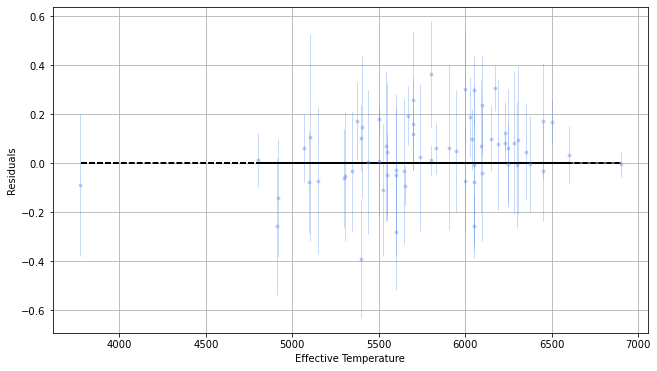

In [11]:
teff1 = np.array([])
diff1 = np.array([])
diffe1 = np.array([])

for i in range(len(teff)):
    if teff[i] > 3500:
        teff1 = np.hstack((teff1, teff[i]))
        diff1 = np.hstack((diff1, diff_u2_c_a[i]))
        diffe1 = np.hstack((diffe1, diff_u2_c_ae[i]))
        
plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(teff1, diff1, yerr = diffe1, fmt='.', elinewidth=1, alpha=0.35, color='cornflowerblue')
plt.plot(teff1, np.zeros(len(teff1)), 'k--')
plt.xlabel('Effective Temperature')
plt.ylabel('Residuals')
plt.grid()
plt.show()

Great! The leftmost point is been removed. We can now fit models to new data

In [12]:
bb_c1, bb_l1, bb_q1 = compute_bic(teff1, diff1)

print('BIC for constant model is ', bb_c1)
print('BIC for linear model is ', bb_l1)
print('BIC for quadratic model is ', bb_q1)

BIC for constant model is  -251.87905189616566
BIC for linear model is  -254.00431545756467
BIC for quadratic model is  -250.08162406019486


In [13]:
# Difference between BIC of linear and constant model is
print(np.abs(bb_c1-bb_l1))

2.1252635613990094


It is greater than two, meaning the linear model is still favoured.

Let's see what happens if we remove cooler star sample from out dataset, i.e., what if we remove all of those targets with effective temperature less than 4500 K.

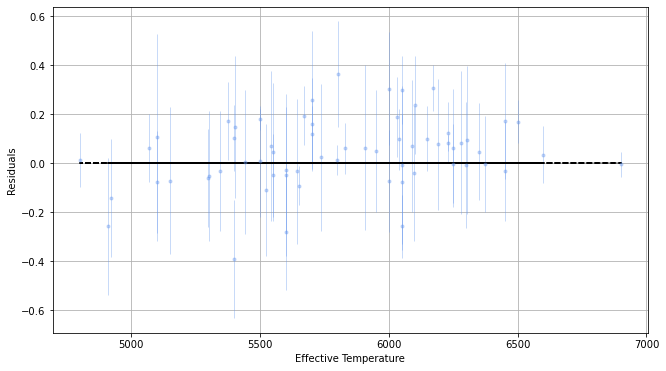

In [14]:
teff2 = np.array([])
diff2 = np.array([])
diffe2 = np.array([])

for i in range(len(teff)):
    if teff[i] > 4500:
        teff2 = np.hstack((teff2, teff[i]))
        diff2 = np.hstack((diff2, diff_u2_c_a[i]))
        diffe2 = np.hstack((diffe2, diff_u2_c_ae[i]))
        
plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(teff2, diff2, yerr = diffe2, fmt='.', elinewidth=1, alpha=0.35, color='cornflowerblue')
plt.plot(teff2, np.zeros(len(teff2)), 'k--')
plt.xlabel('Effective Temperature')
plt.ylabel('Residuals')
plt.grid()
plt.show()

In [15]:
bb_c2, bb_l2, bb_q2 = compute_bic(teff2, diff2)

print('BIC for constant model is ', bb_c2)
print('BIC for linear model is ', bb_l2)
print('BIC for quadratic model is ', bb_q2)

BIC for constant model is  -247.80403683717935
BIC for linear model is  -249.11233184531372
BIC for quadratic model is  -247.31575774580958


I believe now the constant model should be favoured. Let's check.

In [16]:
print(np.abs(bb_c2-bb_l2))

1.3082950081343654


Indeed, the constant model is favoured if we remove cooler stars (< 4500 K) from our sample. Here's the plot of residuals with best fitted model.

Constant value is 0.03991894976832444+/-0.00030965389283113694


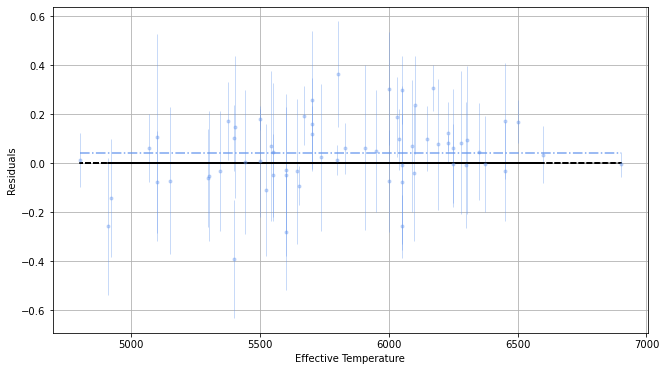

In [17]:
popt, pcov = cft(constant, teff2, diff2)
print('Constant value is ' + str(popt[0]) + '+/-' + str(pcov[0][0]))

t22 = np.linspace(np.min(teff2), np.max(teff2), 1000)

plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(teff2, diff2, yerr = diffe2, fmt='.', elinewidth=1, alpha=0.35, color='cornflowerblue')
plt.plot(t22, constant(t22, *popt), color = 'cornflowerblue', ls = '-.', zorder=3, alpha=0.85)
plt.plot(teff2, np.zeros(len(teff2)), 'k--')
plt.xlabel('Effective Temperature')
plt.ylabel('Residuals')
plt.grid()
plt.show()